In [494]:
#ferramentas necessárias
import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace import sarimax

In [330]:
#lendo o csv e tratando os dados

serie=pd.read_csv('Base teste Cientista de Dados.csv', names=('Data','Valor'), parse_dates=True, index_col=[0])
serie.index =pd.to_datetime(serie.index, format="%m/%d/%Y")
serie['Valor']=serie['Valor'].replace(",",".",regex=True)
serie['Valor']=pd.to_numeric(serie['Valor'])

Text(0.5, 1.0, 'Dados Recebidos')

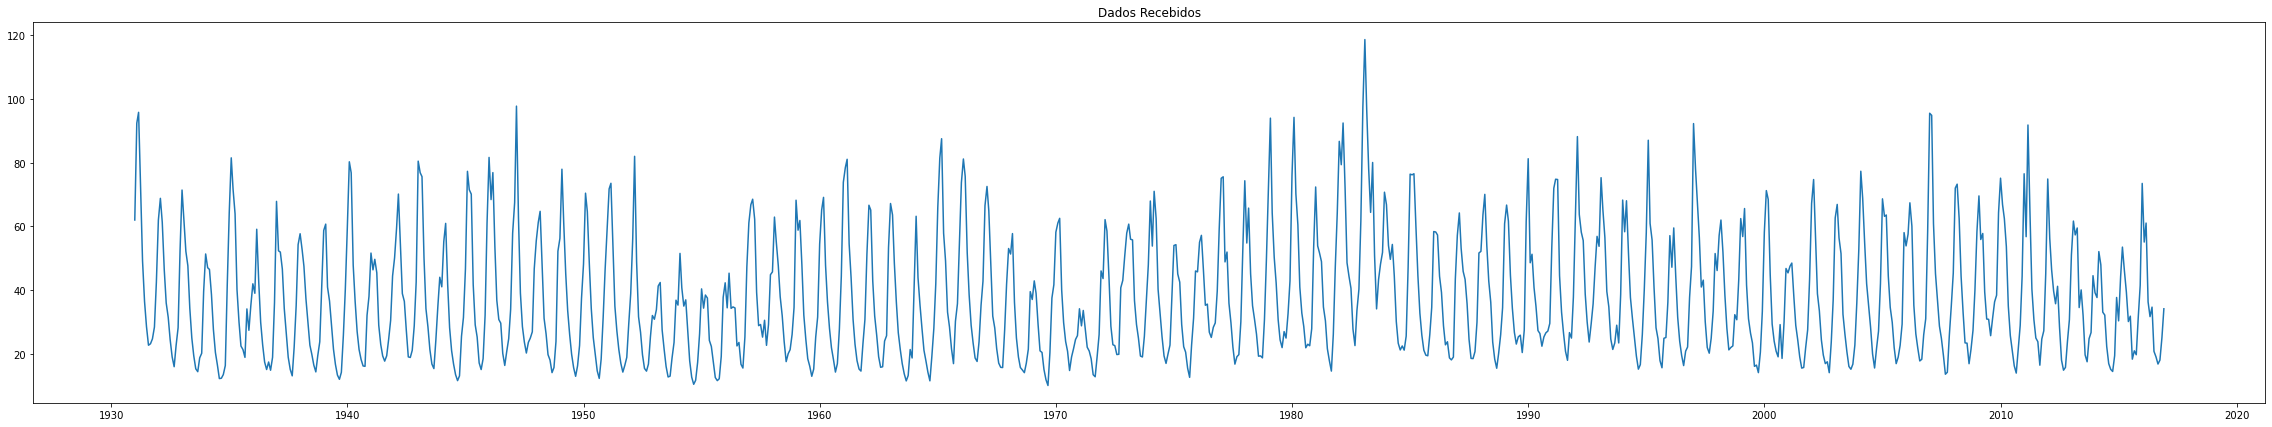

In [331]:
#plotando para se conhecer os dados:

mpl.rcParams['figure.figsize'] = [40,7]
plt.plot(serie.index,serie)
plt.title('Dados Recebidos')

#Observando o comportamento da curva, encontrei um pico de valor muito alto para o dados do ano de 1983. O Valor máximo
#deste ano é mais de 20% maior que o valor máximo para qualquer outro dos 86 anos. Resolvi tratar este ano como um outlier
#e substituir seus dados por outros obtidos com um modelo preditivo (fiz isso mais para frente). 
#Numa situação real, o ideal seria entender se ocorreu
#algum fato extraordinário neste ano que pode ter afetado os dados para decidir como trata-lo.

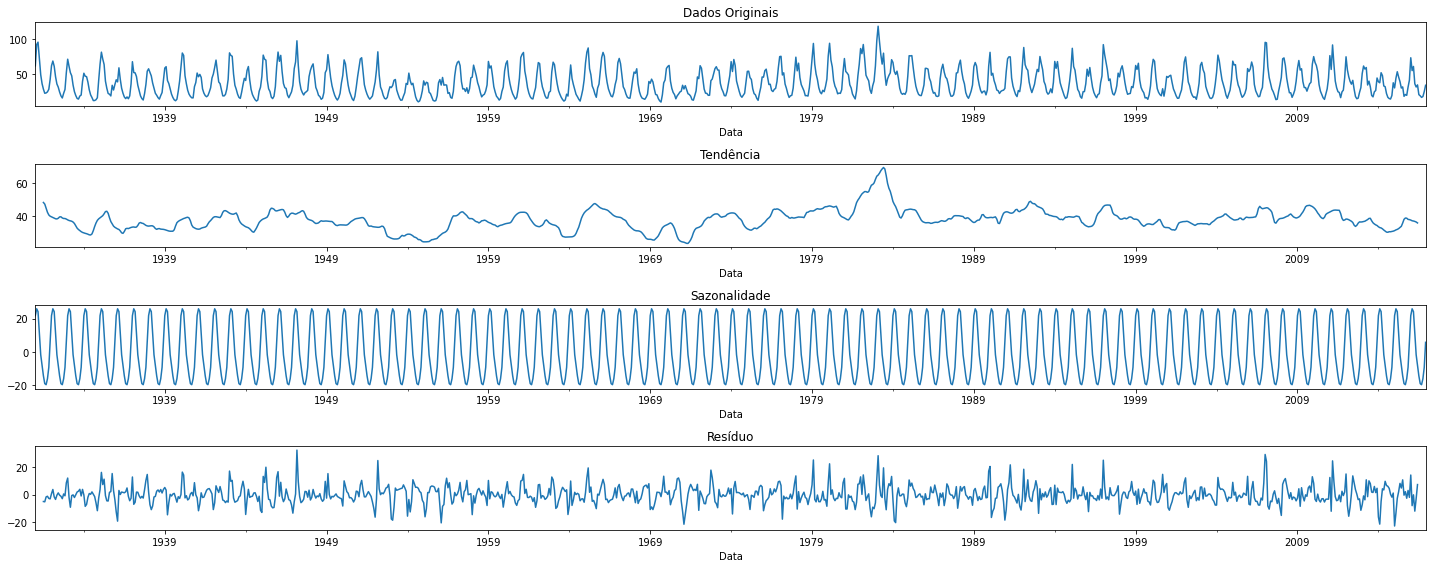

In [390]:
#plotagem para decidir qual modelo utilizar:
result = seasonal_decompose(serie,model='additive')
fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(20,8))
result.observed.plot(ax=ax1, title='Dados Originais')
result.trend.plot(ax=ax2, title='Tendência')
result.seasonal.plot(ax=ax3, title='Sazonalidade')
result.resid.plot(ax=ax4, title='Resíduo')
plt.tight_layout()

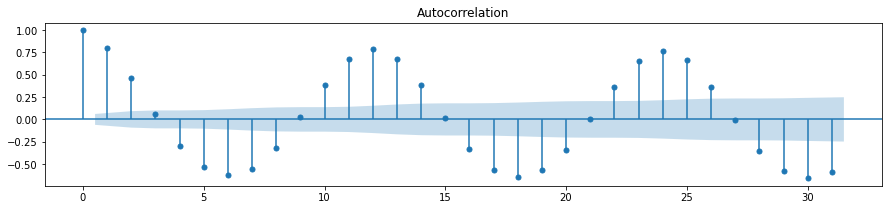

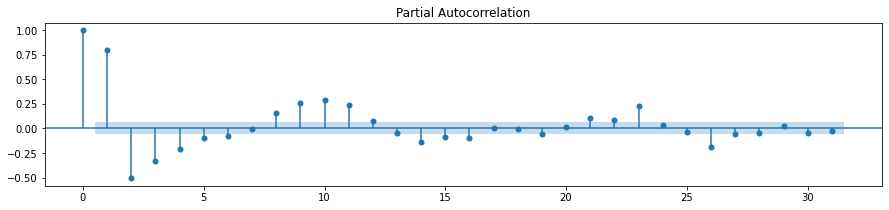

In [386]:
#modelo escolhido: sarima, pois considera a sazonalidade dos dados. Os dados aparentam ser estacionários, mas isso também pode ser considerado no modelo.
#proximo passo: plotar os gráficos de autocorrelação e autocorrelação parcial para decidir os valores de P e Q:
mpl.rcParams['figure.figsize'] = [15,3]
plot1=plot_acf(serie)
plot2=plot_pacf(serie) 

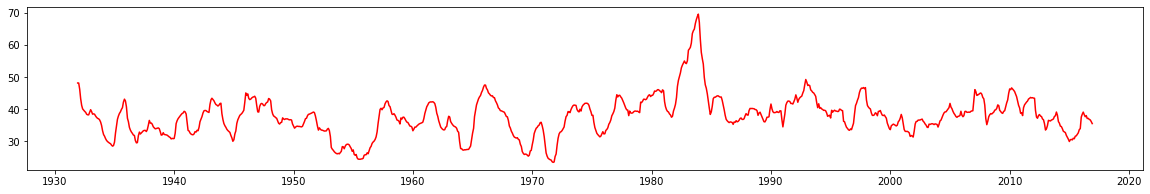

In [425]:
#tracei o valor da média móvel para diferentes períodos de tempo, para tentar encontrar algum padrão que se repete num
#período diferente do que 12 dias, mas não encontrei. Considerei então a sazonalidade como referente os dados de 12 dias,
#que são os ciclos de dias consecutivos a cada ano que tenho os valores.
mpl.rcParams['figure.figsize'] = [20,3]
media_movel = serie.rolling(window=12).mean()
plt.plot(media_movel, color='red')

In [41]:
#aqui fiz um teste para saber quais parametros se adequam melhor para os fatores de sazonalidade do modelo. Testei 
#valores entre 0 e 2 e utilizei a combinação que gera o menor AIC (Akaike Information Criterion):
p = d = q = range(0, 3)
relacao=dict()
pdq_sazonal = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]  #são ciclos de 12 dias
for x in pdq_sazonal:
    try:
        mod = sm.tsa.statespace.SARIMAX(serie,order=(6,1,2),seasonal_order=x,enforce_stationarity=False,enforce_invertibility=False)
        relacao[x] = mod.fit().aic
    except: 
        continue

C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informat

C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informat

In [339]:
#Vendo os valores de aic obtidos, encontrei o mínimo para pdq=(2,1,2). Escolhi então esses valores para o modelo.
relacao

{(0, 0, 0, 12): 7304.387205090185,
 (0, 0, 1, 12): 7121.38313708199,
 (0, 0, 2, 12): 7025.180730714244,
 (0, 1, 0, 12): 7582.163555663472,
 (0, 1, 1, 12): 6852.870241754857,
 (0, 1, 2, 12): 6782.768146479319,
 (0, 2, 0, 12): 8595.173823739364,
 (0, 2, 1, 12): 7495.11348434107,
 (0, 2, 2, 12): 6804.372141726418,
 (1, 0, 0, 12): 7094.250016212331,
 (1, 0, 1, 12): 6920.213654360262,
 (1, 0, 2, 12): 6867.117924270042,
 (1, 1, 0, 12): 7188.89979374291,
 (1, 1, 1, 12): 6837.289371378256,
 (1, 1, 2, 12): 6777.583201122003,
 (1, 2, 0, 12): 7920.5548271901425,
 (1, 2, 1, 12): 7175.564324816985,
 (1, 2, 2, 12): 6807.709094428834,
 (2, 0, 0, 12): 7126.849225092655,
 (2, 0, 1, 12): 6848.946856889097,
 (2, 0, 2, 12): 6847.032580166024,
 (2, 1, 0, 12): 6963.245919211169,
 (2, 1, 1, 12): 6768.179507132989,
 (2, 1, 2, 12): 6761.941720039061,
 (2, 2, 0, 12): 7519.706866989632,
 (2, 2, 1, 12): 6942.392072418679,
 (2, 2, 2, 12): 6790.327613634062}

In [338]:
min(relacao, key=relacao.get)

(2, 1, 2, 12)

In [341]:
#Aqui utilizei este modelo para criar uma nova serie, que é a serie original substituindo os valores do ano de 1983 pelos
#obtidos pelo modelo, já que resolvi considera-los como outliers.
modelo1=sm.tsa.statespace.SARIMAX(serie[0:624],order=(6,1,2),seasonal_order=(2,1,2,12),enforce_stationarity=False,enforce_invertibility=False).fit()
serie2=serie.copy()
serie2[624:636]=pd.DataFrame(modelo1.forecast(steps=12))

C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [555]:
#E aqui recriei o modelo com a nova série e o utilizei para fazer a previsão dos valores para o próximo ano, conforme solicitado.
modelo2=sm.tsa.statespace.SARIMAX(serie2,order=(6,1,2),seasonal_order=(2,1,2,12),enforce_stationarity=False,enforce_invertibility=False).fit()
resposta=pd.DataFrame(modelo2.forecast(steps=12))
#resposta.to_excel('Resposta')
resposta
#obs: a mensagem em fundo rosa do python se refere aos dados faltantes (dias do ano sem valor atribuido), 
#informando que o sistema está desconsiderando eles.

C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,predicted_mean
2017-01-01,53.245087
2017-02-01,58.117271
2017-03-01,58.347257
2017-04-01,45.811450
2017-05-01,33.178071
2017-06-01,26.676245
2017-07-01,20.512611
2017-08-01,16.504733
2017-09-01,15.738775
2017-10-01,19.101609


In [344]:
#Fiz também um gráfico comparando os valores da série original com os obtidos pelo modelo a cada ano (isto é,
#os valores que este modelo gera cada ano com os dados dos anos anteriores). O objetivo era ver se o modelo esta se adequando bem
#e evoluindo bem ao longo dos anos

previsoes=serie.copy()
previsoes[0:120]=None
for k in range(10,86):
    modelok=sm.tsa.statespace.SARIMAX(serie2[0:12*k],order=(6,1,2),seasonal_order=(2,1,2,12),enforce_stationarity=False,enforce_invertibility=False).fit()
    previsoes[12*k:12*(k+1)]=pd.DataFrame(modelok.forecast(steps=12))

C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informat

C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency info

C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency info

C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency info

C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information 

C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\NOVO\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency info

In [380]:
resposta.columns=['Valor']
previsoes_totais=pd.concat([previsoes,resposta])

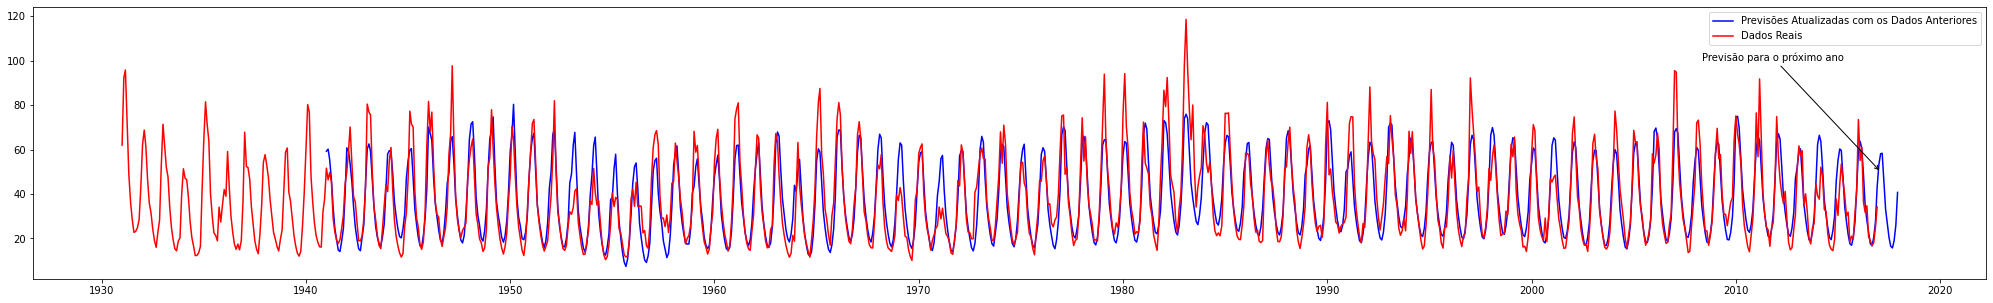

In [554]:
mpl.rcParams['figure.figsize'] = [35,5]
plt.plot(previsoes_totais.index, previsoes_totais, color = 'blue', markersize = 4)
plt.plot(serie.index, serie, color = 'red', markersize = 4)
plt.legend(['Previsões Atualizadas com os Dados Anteriores','Dados Reais'],loc='best')
plt.annotate('Previsão para o próximo ano',xy=(17200,50),xycoords='data',xytext=(14000, 100), arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))
#plt.savefig('Previsão.png',format='png')

plt.show()



In [566]:
#Para ter uma noção da precisão, testei o erro percentual médio e o erro quadrático médio
#da previsão para o período que temos os dados reais:
#Para ter uma noção da precisão, testei o erro percentual médio das previsões para o período que temos os dados reais:

Erro_medio=abs(100*(previsoes['Valor']-serie['Valor'])/(serie['Valor'])).mean()
Erro_quadratico_medio=abs((previsoes['Valor']**2-serie['Valor']**2)).mean()

print('O modelo erra em média', Erro_medio, '%.', '\nA raiz do erro quadrático médio do modelo é de', Erro_quadratico_medio**(0.5), 'Enquanto a serie possui desvio-padrao de', float(serie.std()))






O modelo erra em média 18.69942666567401 %. 
A raiz do erro quadrático médio do modelo é de 24.753179043992475 Enquanto a serie possui desvio-padrao de 19.19602540861732


In [557]:
resposta.to_csv('resposta.csv')